## 결측치 제거 하지 않는 데이터 (카이제곱 및 t-test를 통해 컬럼 선정)

~~~
데이터 전처리 과정
- 컬럼 Occupation, Customer Id, Martial Status, Prizm Code 제외
- 통계적 검정을 통해 컬럼 선별 진행 (t-test, 카이제곱 검정)
    - recommendation이 drop이면 drop함
- 총 43개의 컬럼을 선정
- Rpbust Scaler를 통해 진행
- 이상치는 제거하지 않았음
- 모델을 돌려 결과 나옴

In [134]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

import collections
import time
import warnings
warnings.filterwarnings('ignore')


In [135]:
# 전처리 된 데이터 셋
train = pd.read_csv('./cell2celltrain.csv')

In [136]:
columns_to_drop = ['CustomerID', 'MaritalStatus', 'Occupation', 'PrizmCode']

train = train.drop(columns_to_drop, axis=1)

In [137]:
train_null = train.copy()

In [138]:
null_rows_selector = train_null.isnull().any(axis=1)
null_row_count = train_null[null_rows_selector].shape[0]

df_null = train_null.isnull().groupby(train_null.Churn).sum().transpose()
df_null['total'] = train_null.isnull().sum()
df_null['percent'] = (df_null['total'] / len(train_null)) * 100
df_null = df_null[df_null.total != 0]

print("rows with null values: ", null_row_count, ", {:.2f}%".format((null_row_count / len(train_null) * 100)))
print('columns with null values: ', df_null.shape[0])

df_null

rows with null values:  1295 , 2.54%
columns with null values:  14


Churn,No,Yes,total,percent
MonthlyRevenue,86,70,156,0.305601
MonthlyMinutes,86,70,156,0.305601
TotalRecurringCharge,86,70,156,0.305601
DirectorAssistedCalls,86,70,156,0.305601
OverageMinutes,86,70,156,0.305601
RoamingCalls,86,70,156,0.305601
PercChangeMinutes,159,208,367,0.718945
PercChangeRevenues,159,208,367,0.718945
ServiceArea,12,12,24,0.047015
Handsets,1,0,1,0.001959


In [139]:
pd.concat([train_null.Churn.value_counts(normalize=True).rename("Overall"), train_null[null_rows_selector].Churn.value_counts(normalize=True).rename("within_null_rows")], axis=1)

,Overall,within_null_rows
Churn,,
No,0.711815,0.640154
Yes,0.288185,0.359846


In [140]:
contingency_table = pd.concat([train_null.Churn.value_counts().rename("Overall"), train_null[null_rows_selector].Churn.value_counts()
                               .rename("within_null_rows")], axis=1).transpose()
contingency_table

Churn,No,Yes
Overall,36336,14711
within_null_rows,829,466


In [141]:
from scipy.stats import chi2_contingency

stat, p, dof, expected = chi2_contingency(contingency_table.values)

# p-value 확인
alpha = 0.05 # 유의값 수준
print("p value is " + str(p))

print("Dependent (reject H0)") if p <= alpha else print("Independent (H0 holds true)")

p value is 2.383471731598437e-08
Dependent (reject H0)


In [142]:
train_null

,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,...,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating
0,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,...,0,No,No,0,4,No,0,30,Yes,1-Highest
1,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,...,0,Yes,No,0,5,No,0,30,No,4-Medium
2,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,...,0,Yes,No,0,6,No,0,Unknown,No,3-Good
3,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,...,0,Yes,No,0,6,No,0,10,No,4-Medium
4,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,...,0,No,Yes,0,9,No,1,10,No,1-Highest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.3,...,0,No,No,0,6,No,0,60,No,1-Highest
51043,No,95.17,1745.0,85.0,0.99,45.0,4.7,122.0,15.9,16.7,...,0,No,No,0,9,No,1,60,No,3-Good
51044,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.7,...,0,No,No,0,7,No,1,80,No,5-Low
51045,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0,No,No,0,9,No,0,30,No,5-Low


In [143]:
def chi2test(X, y, alpha=0.05):
    # X: DataFrame
    # y: series
    
    target = y.name
    test_df = []
    for index, col in X.select_dtypes(include=['object']).columns.to_series().items():
        df = pd.concat([y, X[col]], axis=1)
        contingency_table = df.value_counts().rename('counts').reset_index().pivot(index=target, columns=col, values='counts').fillna(0)
        stat, p, dof, expected = chi2_contingency(contingency_table.values)
        test_df.append([target, col, stat, p, 
                      'Dependent (reject H0)' if p <= alpha else 'Independent (H0 holds true)','include' if p <= alpha else 'drop'])
        
    test_df = pd.DataFrame(test_df, columns=["variable1", "variable2", "chi2-stat", "p-value", "result", "recommendation"])
    return test_df

chi2test(train_null.drop('Churn', axis=1), train_null['Churn'])

,variable1,variable2,chi2-stat,p-value,result,recommendation
0,Churn,ServiceArea,959.134195,1.862609e-07,Dependent (reject H0),include
1,Churn,ChildrenInHH,4.618176,3.163486e-02,Dependent (reject H0),include
2,Churn,HandsetRefurbished,45.595205,1.453971e-11,Dependent (reject H0),include
3,Churn,HandsetWebCapable,196.373257,1.292123e-44,Dependent (reject H0),include
4,Churn,TruckOwner,1.157607,2.819623e-01,Independent (H0 holds true),drop
5,Churn,RVOwner,0.581561,4.457013e-01,Independent (H0 holds true),drop
6,Churn,Homeownership,8.783314,3.039984e-03,Dependent (reject H0),include
7,Churn,BuysViaMailOrder,23.993398,9.666660e-07,Dependent (reject H0),include
8,Churn,RespondsToMailOffers,26.688591,2.390287e-07,Dependent (reject H0),include
9,Churn,OptOutMailings,0.000000,1.000000e+00,Independent (H0 holds true),drop


In [144]:
from scipy.stats import ttest_ind

def t_test(X, y, alpha=0.05):
    target = y.name
    print('t_test with alpha', alpha)
    test_df = []
    for index, col in X.select_dtypes(exclude=['object']).columns.to_series().items():
        df = pd.concat([y, X[col]], axis=1)
        ttest_df = df.set_index(target, drop=True).fillna(0)

        stat, p = ttest_ind(ttest_df.loc["Yes"], ttest_df.loc["No"], equal_var=False)
        test_df.append([target, col, stat, p,
                     'Dependent (reject H0)' if p <= alpha else 'Independent (H0 holds true)', 'include' if p <= alpha else 'drop'])

    test_df = pd.DataFrame(test_df, columns=['variable1', 'variable2', 't-test', 'p-value', 'result', 'recommendation'])
    return test_df

t_test(train_null.drop('Churn', axis=1), train_null['Churn'])

t_test with alpha 0.05


,variable1,variable2,t-test,p-value,result,recommendation
0,Churn,MonthlyRevenue,[-3.0178789820785163],[0.0025478602791834805],Dependent (reject H0),include
1,Churn,MonthlyMinutes,[-11.877849954853874],[1.835797057997502e-32],Dependent (reject H0),include
2,Churn,TotalRecurringCharge,[-14.52160176239891],[1.310521238648181e-47],Dependent (reject H0),include
3,Churn,DirectorAssistedCalls,[-4.8450245034580215],[1.2718380411479793e-06],Dependent (reject H0),include
4,Churn,OverageMinutes,[3.687404466662035],[0.00022697324858136802],Dependent (reject H0),include
5,Churn,RoamingCalls,[2.244494743224252],[0.024809892182594908],Dependent (reject H0),include
6,Churn,PercChangeMinutes,[-7.448350298200055],[9.747511469363198e-14],Dependent (reject H0),include
7,Churn,PercChangeRevenues,[2.282802936514573],[0.02245132129026346],Dependent (reject H0),include
8,Churn,DroppedCalls,[-3.5273600982343885],[0.00042039591089024496],Dependent (reject H0),include
9,Churn,BlockedCalls,[-1.2668362619480196],[0.20522435968477423],Independent (H0 holds true),drop


### 1.1. include recommendation이 된 컬럼만 선정하여 train_null_1 재정의

In [146]:
columns_to_drop = ['TruckOwner', 'RVOwner', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard',
                   'NewCellphoneUser', 'NotNewCellphoneUser', 'OwnsMotorcycle', 'BlockedCalls', 
                   'CallForwardingCalls']

train = train.drop(columns_to_drop, axis=1)


In [147]:
len(train.columns)

43

In [148]:
le = LabelEncoder()
object_cols = train.select_dtypes(include=['object']).columns
train[object_cols] = train[object_cols].apply(le.fit_transform)
train.reset_index(drop=True, inplace=True)
train[object_cols]

,Churn,ServiceArea,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,Homeownership,BuysViaMailOrder,RespondsToMailOffers,HandsetPrice,MadeCallToRetentionTeam,CreditRating
0,1,658,0,0,1,0,1,1,8,1,0
1,1,610,1,0,0,0,1,1,8,0,3
2,0,352,1,0,0,1,0,0,15,0,2
3,0,610,0,0,1,0,1,1,0,0,3
4,1,563,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
51042,1,310,0,1,1,0,1,1,13,0,0
51043,0,288,1,0,1,0,1,1,13,0,2
51044,1,288,0,0,1,0,0,0,14,0,4
51045,0,411,1,0,1,1,0,0,8,0,4


In [149]:
from sklearn.preprocessing import RobustScaler
import pandas as pd

def scale_data_with_robust_scaler(data):
    rs = RobustScaler()
    scaled_data = pd.DataFrame(rs.fit_transform(data), columns=data.columns)
    return scaled_data

In [150]:
scale_data_with_robust_scaler(train)

,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,...,BuysViaMailOrder,RespondsToMailOffers,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating
0,1.0,-0.653050,-0.260177,-0.766667,0.000000,-0.073171,0.000000,-1.020134,-2.149425,-0.328571,...,1.0,1.0,1.0,0.0,0.0,-0.142857,0.0,-1.000000,1.0,-0.5
1,1.0,-0.840208,-0.630088,-0.933333,-0.252525,-0.073171,0.000000,0.006711,0.034483,-0.385714,...,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,-1.000000,0.0,1.0
2,0.0,-0.279268,-0.633628,-0.233333,-0.252525,-0.073171,0.000000,0.020134,0.034483,-0.428571,...,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.000000,0.0,0.5
3,0.0,0.902950,1.674336,1.000000,1.000000,-0.073171,0.000000,1.087248,0.965517,7.000000,...,1.0,1.0,0.0,0.0,0.0,0.142857,0.0,-2.142857,0.0,1.0
4,1.0,-0.836203,-0.647788,-0.933333,-0.252525,-0.073171,0.000000,0.033557,0.011494,-0.428571,...,1.0,1.0,0.0,0.0,0.0,0.571429,1.0,-2.142857,0.0,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.900000,...,1.0,1.0,0.0,0.0,0.0,0.142857,0.0,-0.285714,0.0,-0.5
51043,0.0,1.247097,2.440708,1.333333,0.747475,1.024390,15.666667,0.852349,1.862069,1.957143,...,1.0,1.0,0.0,0.0,0.0,0.571429,1.0,-0.285714,0.0,0.5
51044,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.814286,...,0.0,0.0,0.0,0.0,0.0,0.285714,1.0,-0.142857,0.0,1.5
51045,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.428571,...,0.0,0.0,0.0,0.0,0.0,0.571429,0.0,-1.000000,0.0,1.5


In [151]:
train.isnull().sum().sort_values(ascending=False)
train_not_null = train.copy()

In [152]:
train_not_null.dropna(inplace=True)
train_not_null.isnull().sum().sort_values(ascending=False)

Churn                        0
Homeownership                0
Handsets                     0
HandsetModels                0
CurrentEquipmentDays         0
AgeHH1                       0
AgeHH2                       0
ChildrenInHH                 0
HandsetRefurbished           0
HandsetWebCapable            0
BuysViaMailOrder             0
ActiveSubs                   0
RespondsToMailOffers         0
RetentionCalls               0
RetentionOffersAccepted      0
ReferralsMadeBySubscriber    0
IncomeGroup                  0
AdjustmentsToCreditRating    0
HandsetPrice                 0
MadeCallToRetentionTeam      0
ServiceArea                  0
UniqueSubs                   0
MonthlyRevenue               0
UnansweredCalls              0
MonthlyMinutes               0
TotalRecurringCharge         0
DirectorAssistedCalls        0
OverageMinutes               0
RoamingCalls                 0
PercChangeMinutes            0
PercChangeRevenues           0
DroppedCalls                 0
Customer

In [153]:
from imblearn.over_sampling import SMOTE
import pandas as pd

def apply_smote(data, target_variable, random_state=70):
    X = data.drop(target_variable, axis=1)
    y = data[target_variable]

    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    data_resampled = pd.concat([X_resampled, y_resampled], axis=1)
    
    return data_resampled

In [154]:
import matplotlib.pyplot as plt

def plot_bar_chart_with_percent(data, column):
    value_counts = data[column].value_counts()

    ax = value_counts.plot(kind='bar', color=['blue', 'orange'])

    def autolabel_percent(rects):
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2, height,
                    f'{height} ({height / value_counts.sum() * 100:.1f}%)',
                    ha='center', va='bottom')

    autolabel_percent(ax.patches)

    plt.xticks(rotation=360)
    plt.show()

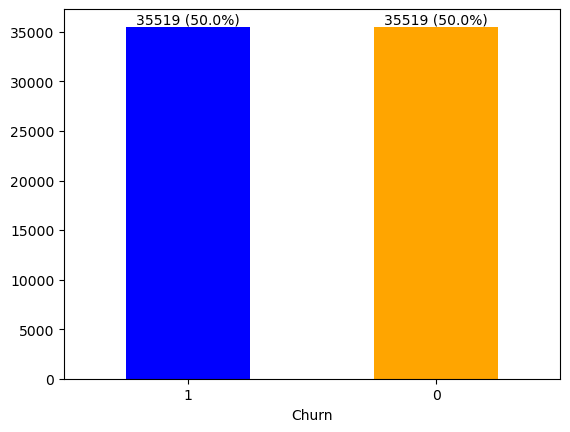

In [155]:
train_rs = apply_smote(train_not_null, 'Churn')
plot_bar_chart_with_percent(train_rs, 'Churn')

In [156]:
from sklearn.model_selection import train_test_split

def split_train_test_data(data, target_variable, test_size=0.3, random_state=70):
    
    y = data[target_variable]
    X = data.drop(columns=[target_variable])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print('X train shape: ', X_train.shape)
    print('Y train shape: ', y_train.shape)
    print('X test shape: ', X_test.shape)
    print('Y test shape: ', y_test.shape)

    return X_train, X_test, y_train, y_test

In [157]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report

def evaluate_models_rs(models, X_train, y_train, X_test, y_test, df):

    for name, model in models:
        kfold = KFold(n_splits=5, random_state=70, shuffle=True)

        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        print(name)
        print(classification_report(y_test, pred, target_names=['No', 'Yes']))

        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred, pos_label=1.0)
        recall = recall_score(y_test, pred, pos_label=1.0)
        f1 = f1_score(y_test, pred, pos_label=1.0)

        model_results = pd.DataFrame({'Model': [name],
                                      'Accuracy': [accuracy],
                                      'Precision': [precision],
                                      'Recall': [recall],
                                      'F1-Score': [f1]})

        df = pd.concat([df, model_results], ignore_index=True)

    return df

models = [
    ('RandomForestClassifier', RandomForestClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier()),
    ('AdaBoostClassifier', AdaBoostClassifier()),
    ('GradientBoostingClassifier', GradientBoostingClassifier()),
    ('LogisticRegression', LogisticRegression())
]

In [158]:
X_train, X_test, y_train, y_test = split_train_test_data(train_rs, 'Churn')

X train shape:  (49726, 42)
Y train shape:  (49726,)
X test shape:  (21312, 42)
Y test shape:  (21312,)


In [159]:
train_rs_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
train_rs_df = evaluate_models_rs(models, X_train, y_train, X_test, y_test,train_rs_df)
train_rs_df

RandomForestClassifier
              precision    recall  f1-score   support

          No       0.75      0.89      0.81     10571
         Yes       0.87      0.70      0.78     10741

    accuracy                           0.80     21312
   macro avg       0.81      0.80      0.80     21312
weighted avg       0.81      0.80      0.79     21312

DecisionTreeClassifier
              precision    recall  f1-score   support

          No       0.69      0.68      0.68     10571
         Yes       0.69      0.70      0.70     10741

    accuracy                           0.69     21312
   macro avg       0.69      0.69      0.69     21312
weighted avg       0.69      0.69      0.69     21312

AdaBoostClassifier
              precision    recall  f1-score   support

          No       0.71      0.77      0.74     10571
         Yes       0.75      0.69      0.72     10741

    accuracy                           0.73     21312
   macro avg       0.73      0.73      0.73     21312
weighted 

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForestClassifier,0.796547,0.867217,0.704124,0.777207
1,DecisionTreeClassifier,0.689940,0.688980,0.701424,0.695147
2,AdaBoostClassifier,0.731044,0.754083,0.692021,0.721721
3,GradientBoostingClassifier,0.777637,0.859660,0.667815,0.751690
4,LogisticRegression,0.572917,0.580335,0.551159,0.565371


# 모델링 파라미터 찾기

In [160]:
from sklearn.model_selection import train_test_split

def split_train_test_data(data, target_variable, test_size=0.3, random_state=70):
    
    y = data[target_variable]
    X = data.drop(columns=[target_variable])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print('X train shape: ', X_train.shape)
    print('Y train shape: ', y_train.shape)
    print('X test shape: ', X_test.shape)
    print('Y test shape: ', y_test.shape)

    return X_train, X_test, y_train, y_test


In [161]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report

def evaluate_models_rs(models, X_train, y_train, X_test, y_test, df):

    for name, model in models:
        kfold = KFold(n_splits=5, random_state=70, shuffle=True)

        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        print(name)
        print(classification_report(y_test, pred, target_names=['No', 'Yes']))

        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred, pos_label=1.0)
        recall = recall_score(y_test, pred, pos_label=1.0)
        f1 = f1_score(y_test, pred, pos_label=1.0)

        model_results = pd.DataFrame({'Model': [name],
                                      'Accuracy': [accuracy],
                                      'Precision': [precision],
                                      'Recall': [recall],
                                      'F1-Score': [f1]})

        df = pd.concat([df, model_results], ignore_index=True)

    return df

models = [
    ('RandomForestClassifier', RandomForestClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier()),
    ('AdaBoostClassifier', AdaBoostClassifier()),
    ('GradientBoostingClassifier', GradientBoostingClassifier()),
    ('LogisticRegression', LogisticRegression())
]

In [162]:
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

def perform_cross_validation(X, y, models):
    results = []
    names = []

    for name, model in models:
        kfold = KFold(n_splits=5, random_state=70, shuffle=True)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)

        print(name, cv_results.mean(), cv_results.std())

models = [
    ('RandomForestClassifier', RandomForestClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier()),
    ('AdaBoostClassifier', AdaBoostClassifier()),
    ('GradientBoostingClassifier', GradientBoostingClassifier()),
    ('LogisticRegression', LogisticRegression())
]

In [169]:
train_test = pd.read_csv('./data2.csv')

In [170]:
train_test

,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,...,AgeHH1,AgeHH2,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating,CreditRating,out,Churn
0,-0.657810,-0.260512,-0.766667,0.000000,-0.052632,0.000000,-1.041096,-2.253012,-0.348485,-0.081081,...,2.000000,0.000000,1.0,0.0,0.000000,-0.166667,0.0,-0.500000,0.0,1.0
1,-0.850829,-0.642596,-0.933333,-0.337838,-0.052632,0.000000,0.006849,0.036145,-0.409091,-0.270270,...,-0.200000,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.0,1.0
2,-0.272321,-0.646252,-0.233333,-0.337838,-0.052632,0.000000,0.020548,0.036145,-0.454545,-0.270270,...,-1.600000,-2.000000,0.0,0.0,0.000000,0.166667,0.0,0.500000,0.0,0.0
3,0.946926,1.737660,1.000000,1.337838,-0.052632,0.000000,1.109589,1.012048,7.424242,1.810811,...,-1.200000,0.000000,0.0,0.0,0.000000,0.166667,0.0,1.000000,0.0,0.0
4,-0.846699,-0.660878,-0.933333,-0.337838,-0.052632,0.000000,0.034247,0.012048,-0.454545,-0.270270,...,0.400000,1.500000,0.0,0.0,0.000000,0.666667,1.0,-0.500000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70283,-0.345607,-0.298928,-0.236795,-0.337838,0.084589,0.000000,0.118791,-0.611794,-0.193924,-0.270270,...,-0.200000,-0.762982,0.0,0.0,0.000000,-0.833333,0.0,0.788946,0.0,1.0
70284,0.506822,1.399441,1.184416,0.571390,0.134958,0.205628,-3.622991,-3.049480,1.625126,2.669592,...,-0.282251,-1.034271,0.0,0.0,0.000000,-0.810486,0.0,1.294372,0.0,1.0
70285,-0.485934,-0.283705,-0.166667,-0.035586,-0.052632,0.000000,-0.912374,0.010779,1.137110,0.476541,...,0.157866,-0.329001,0.0,0.0,0.000000,-0.833333,0.0,1.052668,0.0,1.0
70286,-0.402047,-0.175260,-0.328328,-0.337838,0.265485,0.000000,-1.501451,0.834488,0.189782,-0.270270,...,2.489544,-0.361930,0.0,0.0,0.000000,-0.557193,0.0,0.276140,0.0,1.0


In [171]:
X_train, X_test, y_train, y_test = split_train_test_data(train_test, 'Churn')

X train shape:  (49201, 36)
Y train shape:  (49201,)
X test shape:  (21087, 36)
Y test shape:  (21087,)


In [172]:
perform_cross_validation(X_train, y_train, models)

RandomForestClassifier 0.8034999149071871 0.003394922116018327
DecisionTreeClassifier 0.6997824783984046 0.004119076682711448
AdaBoostClassifier 0.7160829113803789 0.005761476481929667
GradientBoostingClassifier 0.781833677835305 0.002343116751012063
LogisticRegression 0.5876913679537161 0.006746342783560551


In [173]:
train_null_1_ss_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
train_null_1_ss_df = evaluate_models_rs(models, X_train, y_train, X_test, y_test,train_null_1_ss_df)
train_null_1_ss_df

RandomForestClassifier
              precision    recall  f1-score   support

          No       0.77      0.90      0.83     10515
         Yes       0.88      0.73      0.80     10572

    accuracy                           0.81     21087
   macro avg       0.82      0.81      0.81     21087
weighted avg       0.82      0.81      0.81     21087

DecisionTreeClassifier
              precision    recall  f1-score   support

          No       0.70      0.69      0.70     10515
         Yes       0.70      0.71      0.71     10572

    accuracy                           0.70     21087
   macro avg       0.70      0.70      0.70     21087
weighted avg       0.70      0.70      0.70     21087

AdaBoostClassifier
              precision    recall  f1-score   support

          No       0.70      0.76      0.73     10515
         Yes       0.74      0.68      0.71     10572

    accuracy                           0.72     21087
   macro avg       0.72      0.72      0.72     21087
weighted 

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForestClassifier,0.813250,0.880652,0.725880,0.795810
1,DecisionTreeClassifier,0.701570,0.698598,0.711880,0.705177
2,AdaBoostClassifier,0.718737,0.738122,0.680382,0.708077
3,GradientBoostingClassifier,0.785460,0.876213,0.666194,0.756905
4,LogisticRegression,0.585337,0.580175,0.625615,0.602039


# 랜덤 포레스트

~~~
n_estimators
사용되는 Decision Tree의 갯수를 지정
default : 10
무작정 트리 갯수를 늘리면 성능 좋아지는 것 대비 시간이 걸릴 수 있음

min_samples_split
노드를 분할하기 위한 최소한의 샘플 데이터수
→ 과적합을 제어하는데 사용합니다. 값이 작을수록 분할노드가 많아져 과적합 가능성 증가
default : 2

min_samples_leaf

리프노드가 되기 위한 최소한의 샘플 데이터수
→ 과적합을 제어하는데 사용합니다. 값이 작을수록 과적합 가능성 증가
default : 1
불균형 데이터의 경우 특정 클래스 데이터가 극도로 적을 수 있으므로 작은 값으로 설정 필요

max_depth

트리의 최대 깊이
default : None → 완벽하게 클래스 값이 결정될 때까지 분할
또는 데이터 갯수가 min_samples_split보다 작아질 때까지 분할
깊이가 깊어지면 과적합될 수 있으므로 적절히 제어 필요

In [187]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_random_forest(df):
    X = df.drop('Churn', axis=1)
    y = df['Churn']

    param_grid = {
        'n_estimators': [50 ,100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [10, 20, 30],
        'min_samples_split': [10, 20, 30]
    }
    grid_search = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid, cv=5)
    grid_search.fit(X, y)
    best_params = grid_search.best_params_

    model = RandomForestClassifier(**best_params)
    model.fit(X, y)

    importances = model.feature_importances_
    feature_importances = dict(zip(X.columns, importances))
    top_features = sorted(feature_importances, key=feature_importances.get, reverse=True)[:3]

    predictions = model.predict(X)

    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions, pos_label=1)
    recall = recall_score(y, predictions, pos_label=1)
    f1 = f1_score(y, predictions, pos_label=1)
    tn = ((y == 0) & (predictions == 0)).sum()
    fp = ((y == 0) & (predictions == 1)).sum()
    specificity = tn / (tn + fp)
    

    print("Best Parameters:", best_params)
    print("Top Features:", top_features)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("Specificity:", specificity)

evaluate_random_forest(train_test)


Best Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Top Features: ['MonthsInService', 'CurrentEquipmentDays', 'CreditRating']
Accuracy: 0.9952623491918962
Precision: 0.9991969484039349
Recall: 0.9913214204416116
F1-Score: 0.9952436045764237
Specificity: 0.9992032779421808


In [189]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_random_forest(df):
    X = df.drop('Churn', axis=1)
    y = df['Churn']

    param_grid = {
        'n_estimators': [50 ,100, 200, 300],
        'max_depth': [3, 5, 10, 15]
    }
    grid_search = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid, cv=5)
    grid_search.fit(X, y)
    best_params = grid_search.best_params_

    model = RandomForestClassifier(**best_params)
    model.fit(X, y)

    importances = model.feature_importances_
    feature_importances = dict(zip(X.columns, importances))
    top_features = sorted(feature_importances, key=feature_importances.get, reverse=True)[:3]

    predictions = model.predict(X)

    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions, pos_label=1)
    recall = recall_score(y, predictions, pos_label=1)
    f1 = f1_score(y, predictions, pos_label=1)
    tn = ((y == 0) & (predictions == 0)).sum()
    fp = ((y == 0) & (predictions == 1)).sum()
    specificity = tn / (tn + fp)
    

    print("Best Parameters:", best_params)
    print("Top Features:", top_features)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("Specificity:", specificity)

evaluate_random_forest(train_test)

Best Parameters: {'max_depth': 15, 'n_estimators': 100}
Top Features: ['MonthsInService', 'CurrentEquipmentDays', 'CreditRating']
Accuracy: 0.9189050762576827
Precision: 0.92816426244765
Recall: 0.908092419758707
F1-Score: 0.9180186399723852
Specificity: 0.9297177327566584


In [194]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_random_forest(df):
    X = df.drop('Churn', axis=1)
    y = df['Churn']

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [6, 10],
        'min_samples_leaf' :[5, 10],
        'min_samples_split' :[2, 8]
    }
    grid_search = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid, cv=5)
    grid_search.fit(X, y)
    best_params = grid_search.best_params_

    model = RandomForestClassifier(**best_params)
    model.fit(X, y)

    importances = model.feature_importances_
    feature_importances = dict(zip(X.columns, importances))
    top_features = sorted(feature_importances, key=feature_importances.get, reverse=True)[:3]

    predictions = model.predict(X)

    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions, pos_label=1)
    recall = recall_score(y, predictions, pos_label=1)
    f1 = f1_score(y, predictions, pos_label=1)
    tn = ((y == 0) & (predictions == 0)).sum()
    fp = ((y == 0) & (predictions == 1)).sum()
    specificity = tn / (tn + fp)
    

    print("Best Parameters:", best_params)
    print("Top Features:", top_features)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("Specificity:", specificity)

evaluate_random_forest(train_test)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 100}
Top Features: ['MonthsInService', 'CurrentEquipmentDays', 'CreditRating']
Accuracy: 0.7731618483951741
Precision: 0.7757986669731096
Recall: 0.7683815160482586
F1-Score: 0.7720722781335773
Specificity: 0.7779421807420897


# 결과
~~~
랜덤 포레스트 모델의 변수를 바꿔 최적의 모델로 바꾸려 했다.
영향을 가장 많이 끼친 컬럼 : ['MonthsInService', 'CurrentEquipmentDays', 'CreditRating']
최적의 파라미터 : {'max_depth': 15, 'n_estimators': 100, 'min_samples_leaf' : 5, 'min_samples_split' : 5}

Accuracy: 0.8834082631459139
Precision: 0.9109958822632301
Recall: 0.8498463464602777
F1-Score: 0.8793593310662603
Specificity: 0.9169701798315502

~~~
최적의 파라미터 : {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 100}
영향을 가장 많이 끼친 컬럼 : ['MonthsInService', 'CurrentEquipmentDays', 'CreditRating']
Accuracy: 0.7731618483951741
Precision: 0.7757986669731096
Recall: 0.7683815160482586
F1-Score: 0.7720722781335773
Specificity: 0.7779421807420897

# LGBM

~~~
max_depth
기본값 : 6 / 범위 : [0,∞]
최대 트리의 깊이. N이라고 가정하면 2^N개의 리프 노드가 생긴다. 10일 때 최대 1024개의 리프 노트가 생긴다.
일반적으로 Feature 수에 따라 3~6으로 세팅한 후 성능이 증가하고, 오버 피팅이 나지 않을 때까지 늘려간다.
제한된 리소스에 모델을 올려야 할 경우 울며 겨자 먹기로 약간의 성능을 포기하고 depth를 줄이기도 한다.

subsample
기본값 : 1 범위: (0,1]
각각의 스탭마다 사용할 샘플의 비율. 1 이하의 값을 사용하면 오버 피팅을 방지할 수 있다.
개인적으로 cross validation을 주로 쓴다면 크게 중요한 파라미터가 아닌 것 같다.

colsample_bytree
기본값 : 1 / 범위 : (0,1]
각각의 트리(스탭)마다 사용할 칼럼(Feature)의 비율
개인적으로 colsample_* 파라미터 둘 중에 가장 효과가 좋은 것 같음.

lambda [alias: reg_lambda]
기본값 : 1 / 범위 : [0,∞]
L2 정규화(규제) 파라미터이다.
커질수록 보수적인 모델을 생성하고 오버 피팅을 방지해준다. 지나치게 클 경우 언더 피팅이 난다. 
너무 큰 가중치를 그 크기에 비례하여 줄여준다.
noise나 outlier 같은 애들이나 너무 크게 튀는 데이터들을 어느 정도 잡아준다고 보면 된다. 

In [190]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_lgbm(df):
    X = df.drop('Churn', axis=1)
    y = df['Churn']

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10],
        'learning_rate': [0.1, 0.01],
        'colsample_bytree' : [0.1, 0.01]
    }
    grid_search = GridSearchCV(LGBMClassifier(n_jobs=-1), param_grid, cv=5)
    grid_search.fit(X, y)
    best_params = grid_search.best_params_

    model = LGBMClassifier(**best_params)
    model.fit(X, y)

    importances = model.feature_importances_
    feature_importances = dict(zip(X.columns, importances))
    top_features = sorted(feature_importances, key=feature_importances.get, reverse=True)[:3]

    predictions = model.predict(X)

    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions, pos_label=1)
    recall = recall_score(y, predictions, pos_label=1)
    f1 = f1_score(y, predictions, pos_label=1)
    tn = ((y == 0) & (predictions == 0)).sum()
    fp = ((y == 0) & (predictions == 1)).sum()
    specificity = tn / (tn + fp)
    

    print("Best Parameters:", best_params)
    print("Top Features:", top_features)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("Specificity:", specificity)

evaluate_lgbm(train_test)


Best Parameters: {'colsample_bytree': 0.01, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200}
Top Features: ['ThreewayCalls', 'AgeHH2', 'Handsets']
Accuracy: 0.7972626906442067
Precision: 0.9997130010523295
Recall: 0.5946961074436604
F1-Score: 0.7457627118644069
Specificity: 0.9998292738447531
